In [ ]:
import os
print(os.listdir('/kaggle/working/'))


In [5]:
from PIL import Image
import os

# List files to verify what's in the directory
print(os.listdir('/kaggle/input/newdata1/'))

# Load your images
content = Image.open('/kaggle/input/newdata1/taj.jpg')
style = Image.open('/kaggle/input/newdata1/painting.jpg')




['painting.jpg', 'taj.jpg']


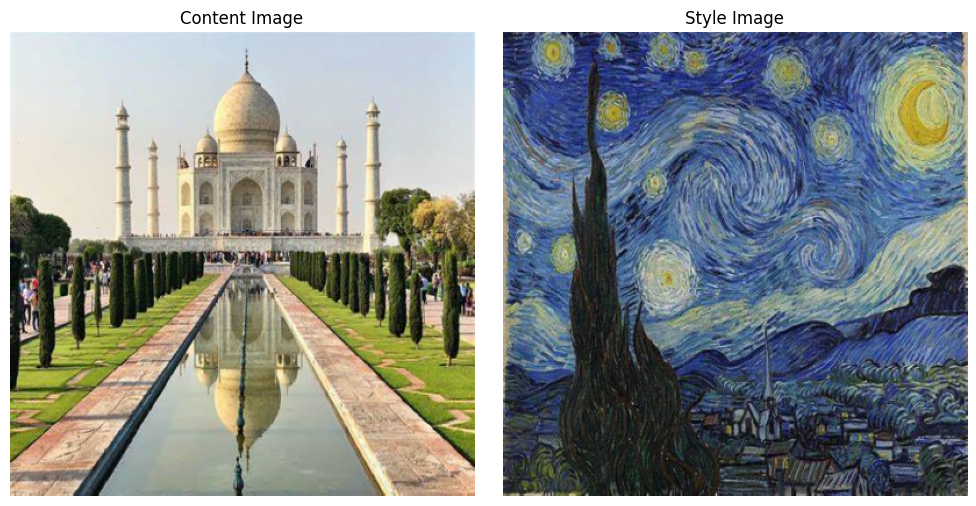

Starting Style Transfer...
Step 0, Style Loss: 0.0138, Content Loss: 9.5706
Step 50, Style Loss: 0.0031, Content Loss: 18.1150
Step 100, Style Loss: 0.0019, Content Loss: 20.9611
Step 150, Style Loss: 0.0015, Content Loss: 21.5623
Step 200, Style Loss: 0.0013, Content Loss: 21.5280
Step 250, Style Loss: 0.0011, Content Loss: 21.3817


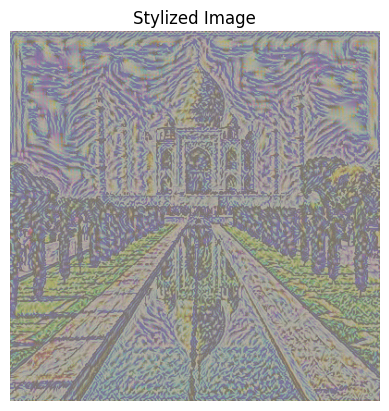

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import copy
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to load and preprocess the image
def load_image(img_path, max_size=400):
    image = Image.open(img_path).convert('RGB')
    size = min(max(image.size), max_size)
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    image = transform(image)[:3, :, :].unsqueeze(0)
    return image.to(device)

# Function to convert tensor to image for display
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze(0)
    image = image.numpy().transpose(1, 2, 0)
    image = image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
    return image.clip(0, 1)

# Content loss module
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
    def forward(self, x):
        self.loss = nn.functional.mse_loss(x, self.target)
        return x

# Gram matrix for style representation
def gram_matrix(input):
    batch_size, feature_maps, h, w = input.size()
    features = input.view(batch_size * feature_maps, h * w)
    G = torch.mm(features, features.t())
    return G.div(batch_size * feature_maps * h * w)

# Style loss module
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self, x):
        G = gram_matrix(x)
        self.loss = nn.functional.mse_loss(G, self.target)
        return x

# Load and display images
content_path = '/kaggle/input/newdata1/taj.jpg'
style_path = '/kaggle/input/newdata1/painting.jpg'


content_img = load_image(content_path)
style_img = load_image(style_path)

# Show input images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(im_convert(content_img))
plt.title("Content Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(im_convert(style_img))
plt.title("Style Image")
plt.axis('off')
plt.tight_layout()
plt.show()

# Load pretrained VGG19
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# Layers used for content and style
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

# Create model
content_losses = []
style_losses = []

model = nn.Sequential()
i = 0
for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f'conv_{i}'
    elif isinstance(layer, nn.ReLU):
        name = f'relu_{i}'
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        name = f'pool_{i}'
    elif isinstance(layer, nn.BatchNorm2d):
        name = f'bn_{i}'

    model.add_module(name, layer)

    if name in content_layers:
        target = model(content_img).detach()
        content_loss = ContentLoss(target)
        model.add_module(f"content_loss_{i}", content_loss)
        content_losses.append(content_loss)

    if name in style_layers:
        target = model(style_img).detach()
        style_loss = StyleLoss(target)
        model.add_module(f"style_loss_{i}", style_loss)
        style_losses.append(style_loss)

# Trim model after last content/style loss
for i in range(len(model) - 1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
        break
model = model[:i + 1]

# Input image
input_img = content_img.clone()
input_img.requires_grad_(True)

# Optimizer (changed to Adam for stability)
optimizer = optim.Adam([input_img], lr=0.01)

# Hyperparameters (reduced style weight to avoid NaN loss)
style_weight = 1e5
content_weight = 1
num_steps = 300

# Style transfer loop
print("Starting Style Transfer...")
for step in range(num_steps):
    optimizer.zero_grad()
    input_img.data.clamp_(0, 1)
    model(input_img)
    style_score = sum(sl.loss for sl in style_losses)
    content_score = sum(cl.loss for cl in content_losses)

    if torch.isnan(style_score) or torch.isnan(content_score):
        print(f"NaN encountered at step {step}, aborting!")
        break

    loss = style_score * style_weight + content_score * content_weight
    loss.backward()
    optimizer.step()

    if step % 50 == 0:
        print(f"Step {step}, Style Loss: {style_score.item():.4f}, Content Loss: {content_score.item():.4f}")

# Clamp final image
input_img.data.clamp_(0, 1)

# Show result
plt.figure()
plt.title("Stylized Image")
plt.imshow(im_convert(input_img))
plt.axis('off')
plt.show()
